In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)

CSV_PATH = "./data/data_nervioso.csv"


In [2]:
df = pd.read_csv(CSV_PATH, thousands=".", decimal=",")

bad_values = ["Sense especificar", "Altres", "ALTRES", "SENSE ESPECIFICAR", "VARIOS"]

df = df.dropna()                     # remove NaNs
df = df[~df.isin(bad_values).any(axis=1)]

translations = {
    'ANALGESICOS': "Analgesics",
    'ANTIEPILEPTICOS': "Antiepileptics",
    'PSICOLEPTICOS': "Psycholeptics",        
    'ANTIPARKINSONIANOS': "Antiparkinsonians",
    'PSICOANALEPTICOS': "Psychoanaleptics",  
    'ANESTESICOS': "Anesthetics",
    'OTROS FARMACOS QUE ACTUAN SOBRE EL SISTEMA NERVIOSO': "Other nervous-system drugs"
}

df["grup ATC nivell 2"] = df["grup ATC nivell 2"].replace(translations)

print("Shape:", df.shape)
df.head()


Shape: (835414, 18)


,any,mes,codi de la regió sanitària,regió sanitària,grup d'edat,sexe,codi del grup ATC nivell 1,grup ATC nivell 1,codi del grup ATC nivell 2,grup ATC nivell 2,codi del grup ATC nivell 3,grup ATC nivell 3,codi del grup ATC nivell 4,grup ATC nivell 4,nombre de receptes,nombre d'envasos,import íntegre,import aportació CatSalut
0,2016,1,61,LLEIDA,0-1,Dona,N,SISTEMA NERVIOSO,N02,Analgesics,N02B,OTROS ANALGESICOS Y ANTIPIRETICOS,N02BE,Anilidas,3050,3050,723.27,447.52
1,2016,1,61,LLEIDA,0-1,Dona,N,SISTEMA NERVIOSO,N03,Antiepileptics,N03A,ANTIEPILEPTICOS,N03AG,Derivados de los acidos grasos,10,10,30.13,27.12
2,2016,1,61,LLEIDA,0-1,Dona,N,SISTEMA NERVIOSO,N03,Antiepileptics,N03A,ANTIEPILEPTICOS,N03AX,Otros antiepilepticos,10,10,28.32,25.49
3,2016,1,61,LLEIDA,0-1,Dona,N,SISTEMA NERVIOSO,N05,Psycholeptics,N05B,ANSIOLITICOS,N05BB,Derivados del difenilmetano,120,120,18.72,10.96
4,2016,1,61,LLEIDA,0-1,Home,N,SISTEMA NERVIOSO,N02,Analgesics,N02B,OTROS ANALGESICOS Y ANTIPIRETICOS,N02BB,Pirazolonas,10,10,2.50,1.25


In [3]:
df.describe(include="all")


,any,mes,codi de la regió sanitària,regió sanitària,grup d'edat,sexe,codi del grup ATC nivell 1,grup ATC nivell 1,codi del grup ATC nivell 2,grup ATC nivell 2,codi del grup ATC nivell 3,grup ATC nivell 3,codi del grup ATC nivell 4,grup ATC nivell 4,nombre de receptes,nombre d'envasos,import íntegre,import aportació CatSalut
count,835414.000000,835414.000000,835414,835414,835414,835414,835414,835414,835414,835414,835414,835414,835414,835414,835414.000000,835414.000000,835414.000000,835414.000000
unique,NaN,NaN,7,7,24,2,1,1,7,7,18,18,59,57,NaN,NaN,NaN,NaN
top,NaN,NaN,78,BARCELONA,60-64,Home,N,SISTEMA NERVIOSO,N05,Psycholeptics,N05A,ANTIPSICOTICOS,N02BE,Derivados de la benzodiazepina,NaN,NaN,NaN,NaN
freq,NaN,NaN,154934,154934,53987,417844,835414,835414,256503,256503,157584,157584,26280,65092,NaN,NaN,NaN,NaN
mean,2018.777087,6.264009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1011.363889,1011.456893,3534.585002,3269.466656
std,1.894207,3.438548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2119.138952,2120.473237,15028.785705,14261.726177
min,2016.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,10.000000,0.000000,0.000000
25%,2017.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,50.000000,34.420000,29.340000
50%,2019.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.000000,210.000000,219.150000,187.150000
75%,2020.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1030.000000,1030.000000,1385.137500,1221.692500


In [4]:
def age_sort_key(age_str):
    # Handle special categories
    if age_str == "Altres":
        return 999
    if age_str == "Sense especificar":
        return 1000
    if age_str == "85+":   # our replaced "Més de 84 anys"
        return 85

    # Extract starting number (e.g., "20-24" → 20)
    m = re.match(r"(\d+)", age_str)
    if m:
        return int(m.group(1))
    return None


df["age_key"] = df["grup d'edat"].apply(age_sort_key)
age_counts = df.groupby(["grup d'edat", "age_key"])["nombre de receptes"].sum()
age_counts = age_counts.reset_index().sort_values("age_key")
ordered_ages = age_counts["grup d'edat"].tolist()

df["grup d'edat"] = pd.Categorical(
    df["grup d'edat"],
    categories=ordered_ages,
    ordered=True
)

### Analyses

In [5]:
df_nerv = df

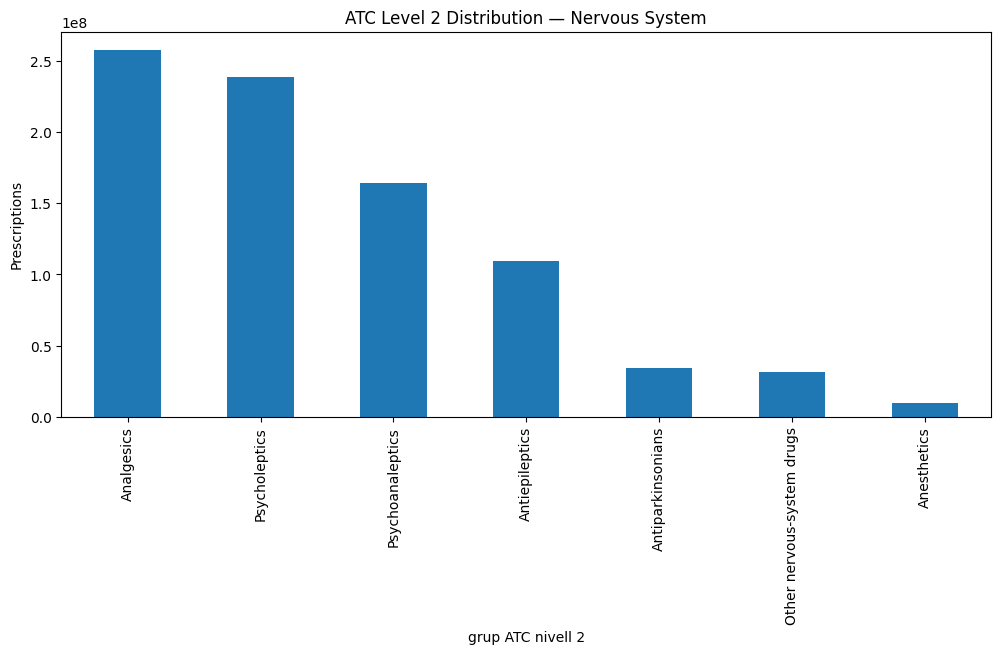

In [6]:
plt.figure(figsize=(12,5))
df_nerv.groupby("grup ATC nivell 2")["nombre de receptes"].sum()\
       .sort_values(ascending=False).plot(kind="bar")
plt.title("ATC Level 2 Distribution — Nervous System")
plt.ylabel("Prescriptions")
plt.xticks()
plt.show()


C:\Users\gerar\AppData\Local\Temp\ipykernel_7636\3795462095.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_nerv.groupby("grup d'edat")["nombre de receptes"].sum().plot(kind="bar")


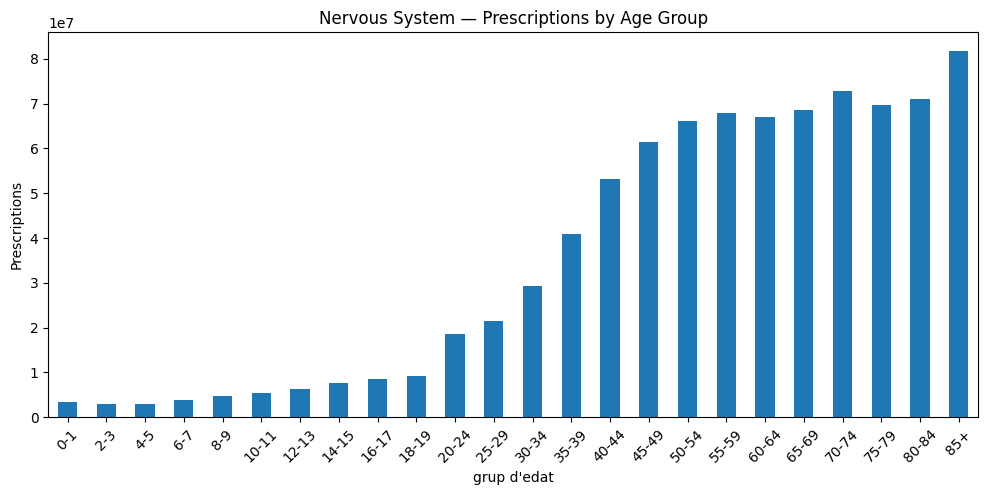

In [7]:
plt.figure(figsize=(12,5))
df_nerv.groupby("grup d'edat")["nombre de receptes"].sum().plot(kind="bar")
plt.title("Nervous System — Prescriptions by Age Group")
plt.ylabel("Prescriptions")
plt.xticks(rotation=45)
plt.show()


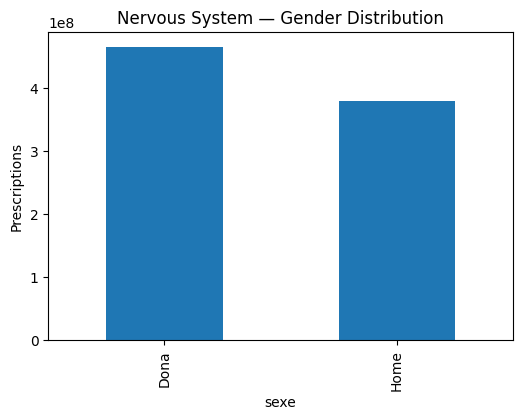

In [8]:
plt.figure(figsize=(6,4))
df_nerv.groupby("sexe")["nombre de receptes"].sum().plot(kind="bar")
plt.title("Nervous System — Gender Distribution")
plt.ylabel("Prescriptions")
plt.show()


### level 2 analyses

C:\Users\gerar\AppData\Local\Temp\ipykernel_7636\4105200336.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["grup d'edat", "grup ATC nivell 2"])["nombre de receptes"]


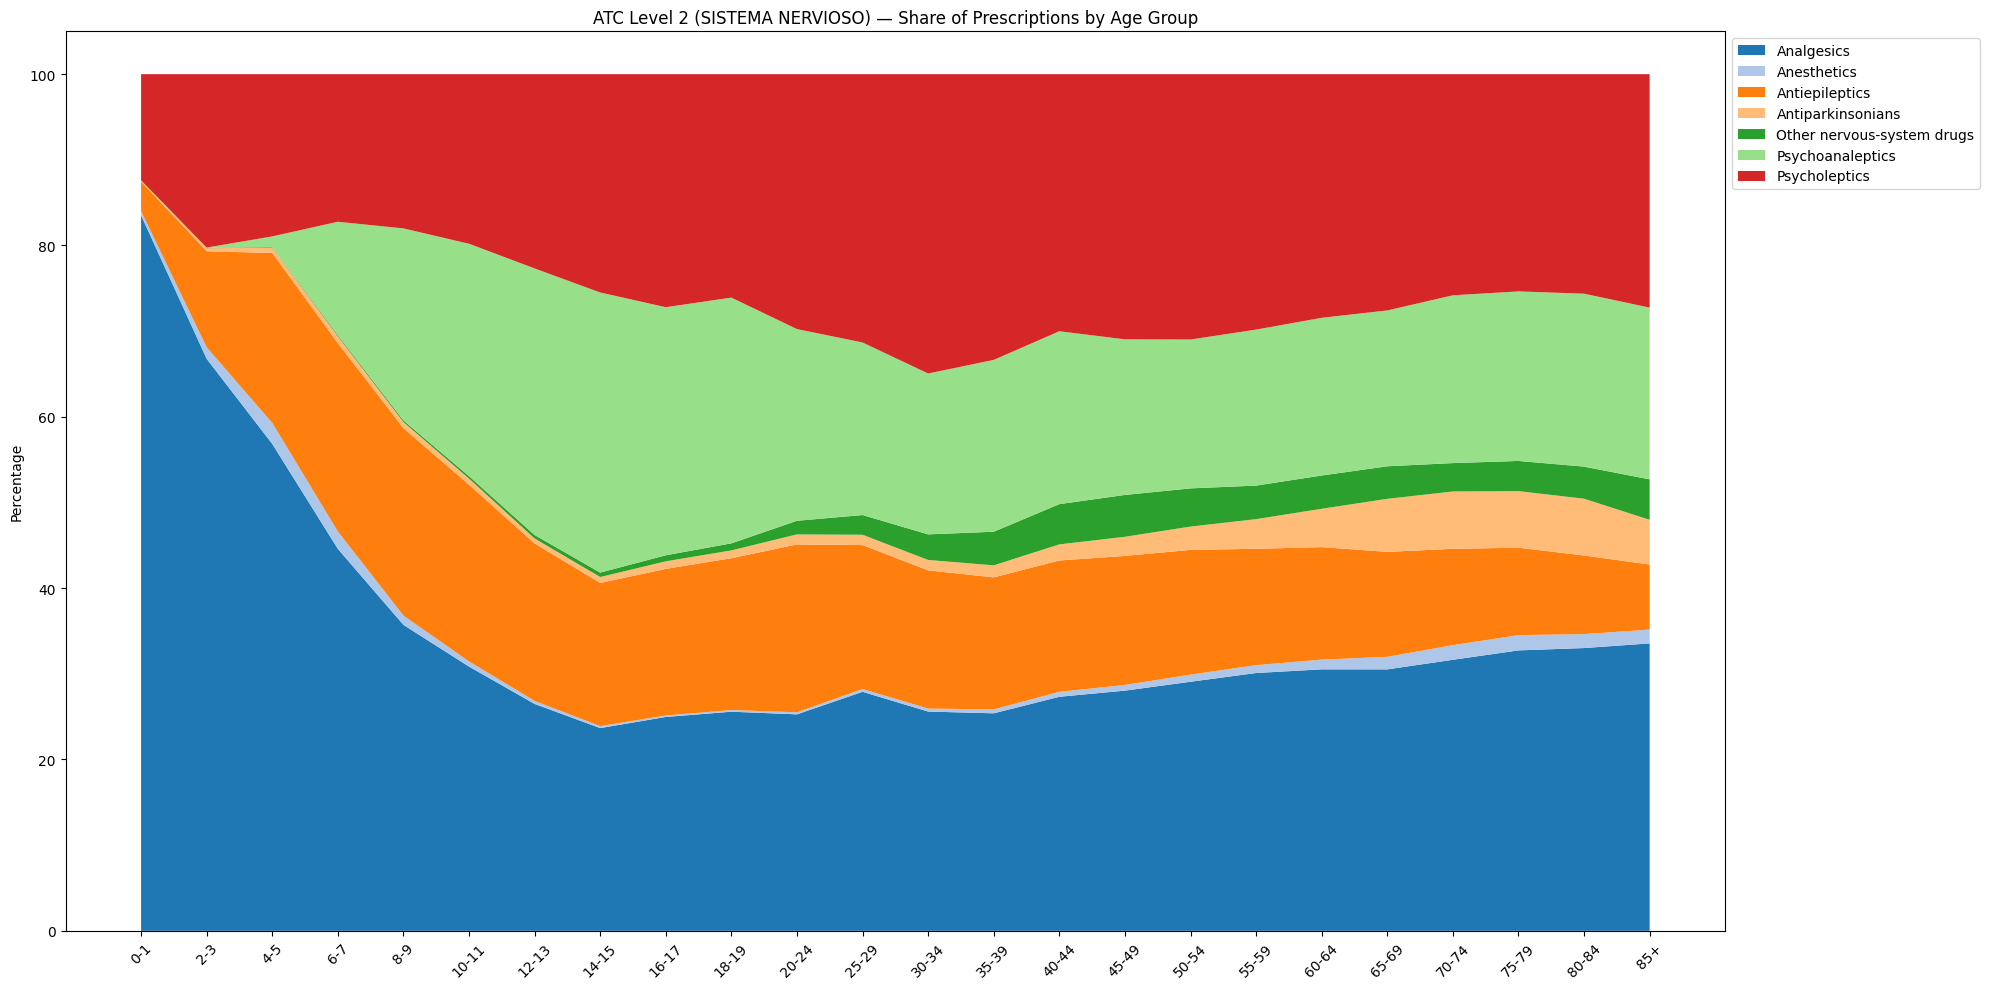

In [9]:
# Aggregate by age × level 2
lvl2_by_age = (
    df_nerv
    .groupby(["grup d'edat", "grup ATC nivell 2"])["nombre de receptes"]
    .sum()
    .unstack(fill_value=0)
)

# Ensure age ordering (same as your original code)
lvl2_by_age = lvl2_by_age.loc[df["grup d'edat"].cat.categories]

# Normalize to percentage per age group
lvl2_pct = lvl2_by_age.div(lvl2_by_age.sum(axis=1), axis=0) * 100

# Use a nice distinct palette
colors = sns.color_palette("tab20", n_colors=len(lvl2_pct.columns))

# Plot
plt.figure(figsize=(20, 10))
plt.stackplot(
    lvl2_pct.index,
    lvl2_pct.T,
    colors=colors,
    labels=lvl2_pct.columns,
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylabel("Percentage")
plt.title("ATC Level 2 (SISTEMA NERVIOSO) — Share of Prescriptions by Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interpretation of ATC Level 2 (Sistema Nervioso) — Share of Prescriptions by Age Group

This plot reveals how *different types of nervous-system medications* dominate at different stages of life. Even within the same ATC Level 1 category, the composition shifts dramatically across age, telling a multi-layered story about pain, mental health, neurological disease, and aging.



**1. Childhood (0–14): Analgesics dominate almost entirely**
- **Analgesics (painkillers)** make up *90–95%* of all Nervioso prescriptions.  
- Very little prescribing of:
  - antiepileptics  
  - anesthetics  
  - psychoactive medications  

**→ Early-life prescribing in the Nervioso group is almost exclusively pain relief**, reflecting injuries, fevers, infections, and acute medical care.


**2. Adolescence to Early Adulthood (10–30): A sharp diversification**
- **Analgesics fall sharply** from ~95% → ~30%.
- **Antiepileptics increase and stabilize.**
- **Psychoanaleptics (antidepressants, stimulants)** rise dramatically.
- **Psycholeptics (anxiolytics, sedatives)** also become significant.

**→ This is the first major transition: mental-health–related medications start to take over.**  
Typical reasons include:
- onset of anxiety and depression  
- sleep disorders  
- ADHD treatments  
- epilepsy diagnoses in adolescents  


**3. Midlife (30–60): Psychoactive medications become dominant**
- **Psychoanaleptics + Psycholeptics** together form the largest share.  
- Analgesics remain important but are no longer the only major category.  
- Small but growing use of:
  - **antiparkinsonian drugs**
  - **other neurological therapies**

**→ In midlife, Nervioso prescribing is driven primarily by mental-health and chronic pain management**, not acute pain.



**4. Older Age (60–85+): Pain returns, but psychoactives remain high**
- **Analgesics rise again**, becoming the most significant category for chronic pain.  
- **Psycholeptics remain substantial** (sedatives, anxiolytics, hypnotics).  
- **Antiparkinsonian medications increase modestly**, reflecting neurodegenerative disease.  
- Antiepileptics remain relevant but decline in relative share.

**→ In older adults, nervous-system prescribing is dominated by chronic pain, mental-health medication, and neurodegenerative treatments.**



**5. “Altres” and “Sense especificar” spikes**
- Irregular jumps in the 85+ and unclassified groups likely reflect:
  - small-group noise  
  - institutional prescribing  
  - data categorization artifacts  



**Bottom Line**
Nervous-system medication needs follow **three distinct life phases**:

**Childhood → dominated by analgesics**  
**Adolescence & midlife → dominated by psychoactive medications**  
**Older age → analgesics + psychoactives + neurodegenerative treatments**

Aging reshapes the Nervioso category completely, revealing evolving mental-health, neurological, and pain-related needs across the lifespan.


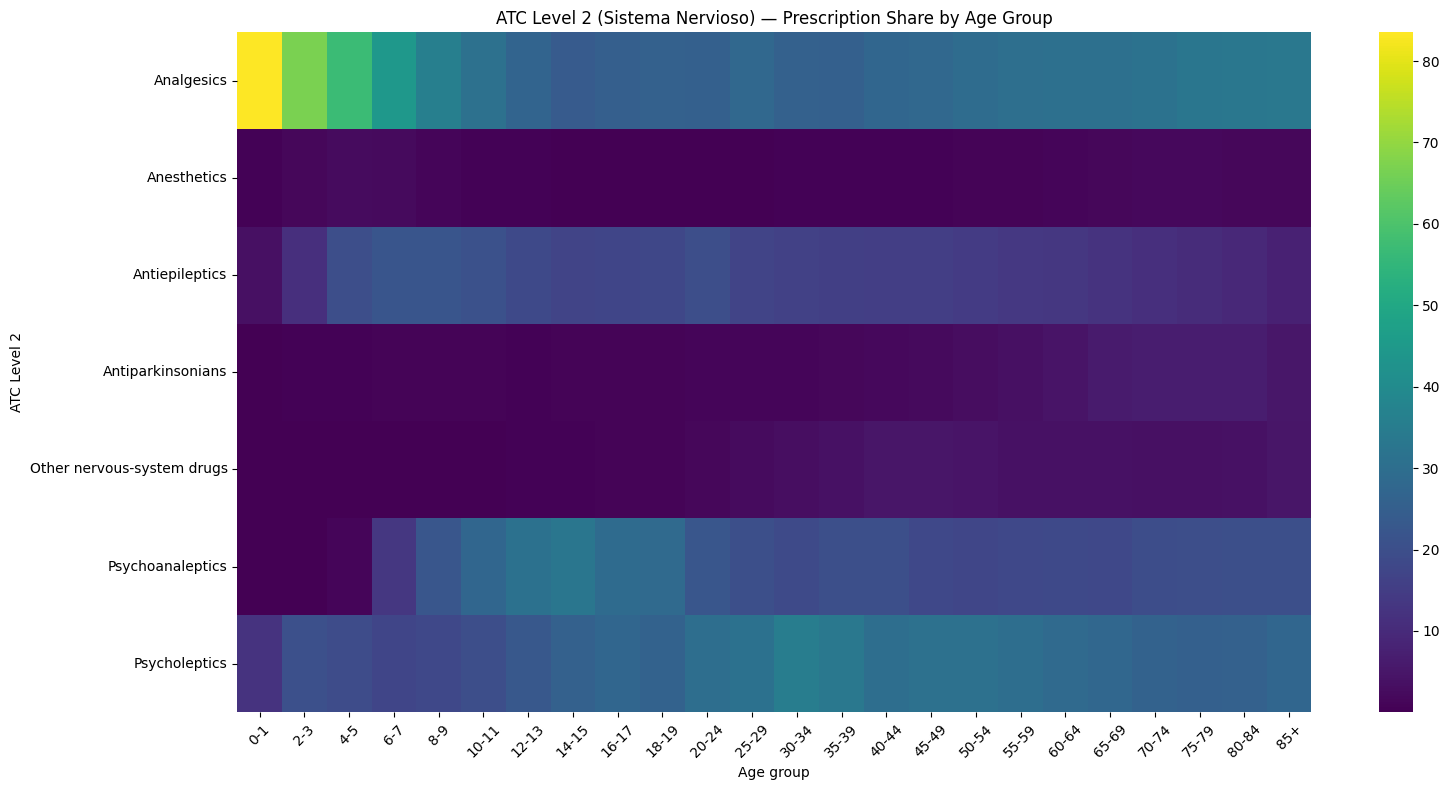

In [10]:
plt.figure(figsize=(16, 8))
sns.heatmap(lvl2_pct.T, cmap="viridis", annot=False)
plt.title("ATC Level 2 (Sistema Nervioso) — Prescription Share by Age Group")
plt.ylabel("ATC Level 2")
plt.xlabel("Age group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The heatmap highlights patterns that are harder to see in the stackplot:

**1. Psychoanaleptics have a very sharp, well-defined peak early (10-17)**  
This appears as a bright band centered on teen/young-adult years — more precise than what the stackplot suggests.

**2. Psycholeptics steadily climb with age**  
The gradient transitions from darker to brighter toward midlife and older ages, showing:
- increasing anxiety treatment,  
- insomnia/hypnotics,  
- sedative use in older populations.  

This is smoother and more gradual in the heatmap than in the stackplot.

**3. Antiepileptic use is stable but slowly declines with age**  
A subtle pattern:  
- stronger in childhood/teens,  
- weakens progressively through adulthood,  
- small rise again in the 85+ group.

**4. Antiparkinsonians show late-life growth**  
The low-intensity band appears only around age 55+ onward — a clear signature of neurodegenerative conditions emerging.

**5. “Otros fármacos” are consistently minor**  
The faint purple line confirms this group stays low across the entire lifespan.

### level 3 analyses

C:\Users\gerar\AppData\Local\Temp\ipykernel_7636\883391844.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["grup d'edat", "grup ATC nivell 3"])["nombre de receptes"]


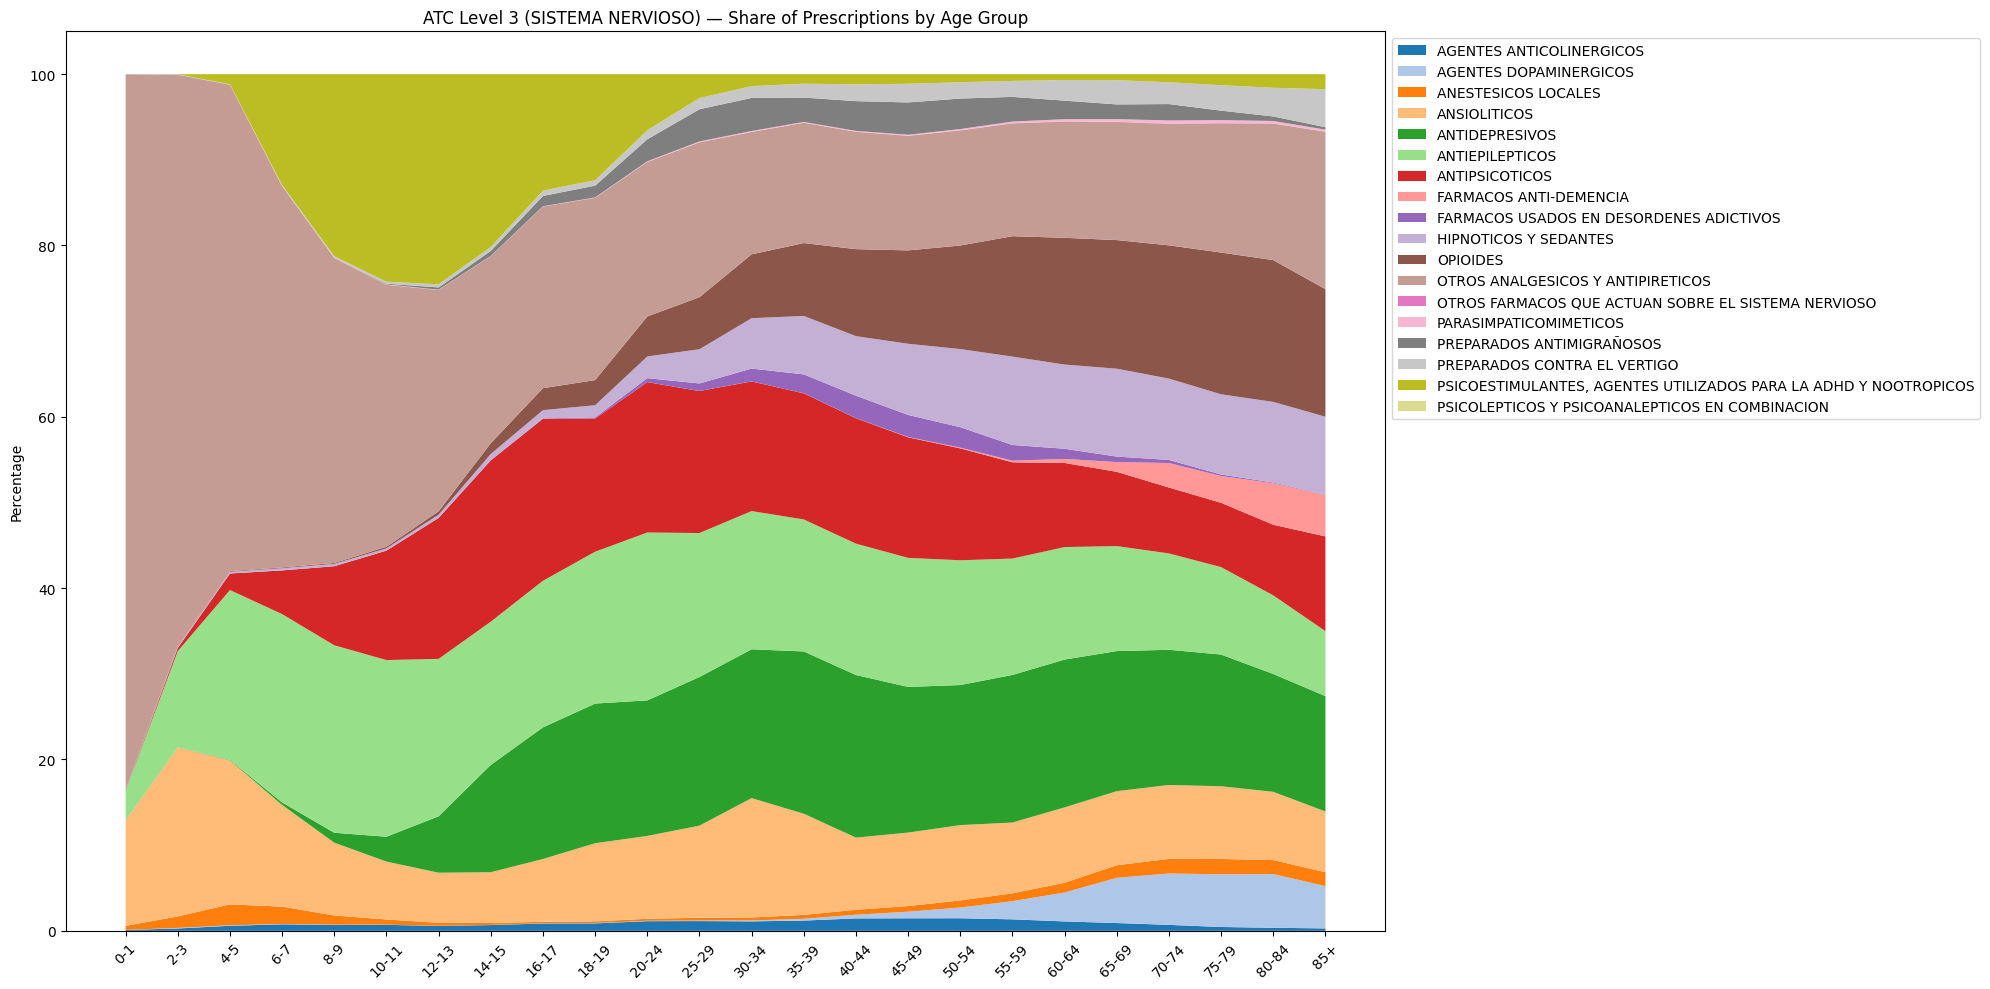

In [11]:
# Aggregate by age × level 3
lvl3_by_age = (
    df_nerv
    .groupby(["grup d'edat", "grup ATC nivell 3"])["nombre de receptes"]
    .sum()
    .unstack(fill_value=0)
)

# Ensure age ordering (same as your original code)
lvl3_by_age = lvl3_by_age.loc[df["grup d'edat"].cat.categories]

# Normalize to percentage per age group
lvl3_pct = lvl3_by_age.div(lvl3_by_age.sum(axis=1), axis=0) * 100

# Use a nice distinct palette
colors = sns.color_palette("tab20", n_colors=len(lvl3_pct.columns))

# Plot
plt.figure(figsize=(20, 10))
plt.stackplot(
    lvl3_pct.index,
    lvl3_pct.T,
    colors=colors,
    labels=lvl3_pct.columns,
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylabel("Percentage")
plt.title("ATC Level 3 (SISTEMA NERVIOSO) — Share of Prescriptions by Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ATC Level 3 (Sistema Nervioso) — Detailed Interpretation by Age Group

This ATC Level 3 view reveals the *fine-grained structure* of how nervous-system medications shift across the lifespan. It uncovers **which exact drug families drive the major Level 2 patterns** observed earlier.  

Even within a single Level 2 category, the composition changes dramatically with age — showing distinct clusters of neurological, psychiatric, and pain-related needs.

**1. Childhood (0–14): Pain dominates, led by antipyretic/analgesic combinations**
- The huge early-age block is driven mostly by **“Otros analgésicos y antipiréticos”**, representing fever/pain treatments.
- **Local anesthetics** appear in small amounts (procedural medicine).
- **Psychoactive or neurological drugs are almost absent**, except minimal antiepileptic use.

**→ Childhood Nervioso medication = almost entirely acute pain + fever management.**

**2. Adolescence (10–19): A major diversification begins**
Sharp transitions appear:
- **Antidepressants** start rising.
- **Anxiolytics** also enter at low but increasing levels.
- **Antiepileptics** are more visible.
- **Stimulants (TDAH/ADHD)** emerge clearly for the first time.
- Pain-related categories shrink substantially.

**→ Adolescence marks the shift from physical-pain–driven prescribing to mental-health and neurological conditions.**

**3. Young Adults (20–35): The peak of mood and anxiety treatment**
This period is dominated by:
- **Antidepressants (very strong peak)**  
- **Anxiolytics**  
- **Antipsychotics (moderate rise)**  
- **Hypnotics & sedatives**  
- **Stimulants for ADHD/nootropics** (clear but not huge)

Pain medications remain present but no longer dominant.

**→ The “mental-health load” of the population peaks here.**

This reflects known patterns:
- depression peaks in early adulthood  
- generalized anxiety disorder and panic disorder begin  
- sleep disorders and stress-related symptoms increase  
- ADHD persists into adulthood for many patients  

**4. Midlife (35–60): Chronic pain + psychiatric medication combination**
This age range shows a *blended pattern*:
- **Antidepressants and anxiolytics remain very high**, slightly declining after ~45.
- **Opioids** rise gradually (chronic pain, postsurgical pain, musculoskeletal issues).
- **Hypnotics and sedatives** stay consistently elevated.
- **Anti-dementia drugs** appear at low levels around late 50s.

**→ Midlife Nervioso prescribing = chronic pain + psychiatric symptoms + emerging neurodegeneration.**

**5. Older Age (60–85+): A shift toward neurological aging & pain**
Key late-age features:
- **Opioids** increase significantly (chronic degenerative pain).  
- **Anti-dementia drugs** become more visible.  
- **Antiparkinsonian drugs** steadily rise (neurodegenerative conditions).  
- **Sedatives and anxiolytics remain high**, consistent with insomnia, anxiety, and behavioral symptoms in older adults.  
- **Antidepressants remain substantial**, though lower than in middle age.

**→ Aging produces a “triple burden”: pain, neurodegeneration, and psychiatric symptoms.**

**6. Very old age (85+): Noisy but consistent patterns**
- **Pain drugs rise again.**
- **Opioids spike** (end-of-life care, cancer pain, severe chronic pain).
- **Antidementia + antiparkinsonian drugs** remain present.
- Classification noise increases slightly (Altres, Sense especificar).

---

The Level 3 plot shows **four distinct pharmacological eras**:

**Childhood → Fever/pain (antipyretics/analgesics)**  
**Adolescence → Neuropsychiatric onset (antidepressants, anxiolytics, ADHD meds)**  
**Midlife → Psychiatric + chronic pain (antidepressants, sedatives, opioids)**  
**Older age → Neurodegeneration + chronic pain (antiparkinsonians, anti-dementia, opioids, sedatives)**  

Each category paints a detailed picture of how **neurological, psychiatric, and pain-related needs evolve across the lifespan**.


In [12]:
df_nerv["grup ATC nivell 2"].unique()

array(['Analgesics', 'Antiepileptics', 'Psycholeptics',
       'Antiparkinsonians', 'Psychoanaleptics', 'Anesthetics',
       'Other nervous-system drugs'], dtype=object)

C:\Users\gerar\AppData\Local\Temp\ipykernel_7636\1902789081.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["grup d'edat", "grup ATC nivell 3"])["nombre de receptes"]


IndexError: index 0 is out of bounds for axis 0 with size 0

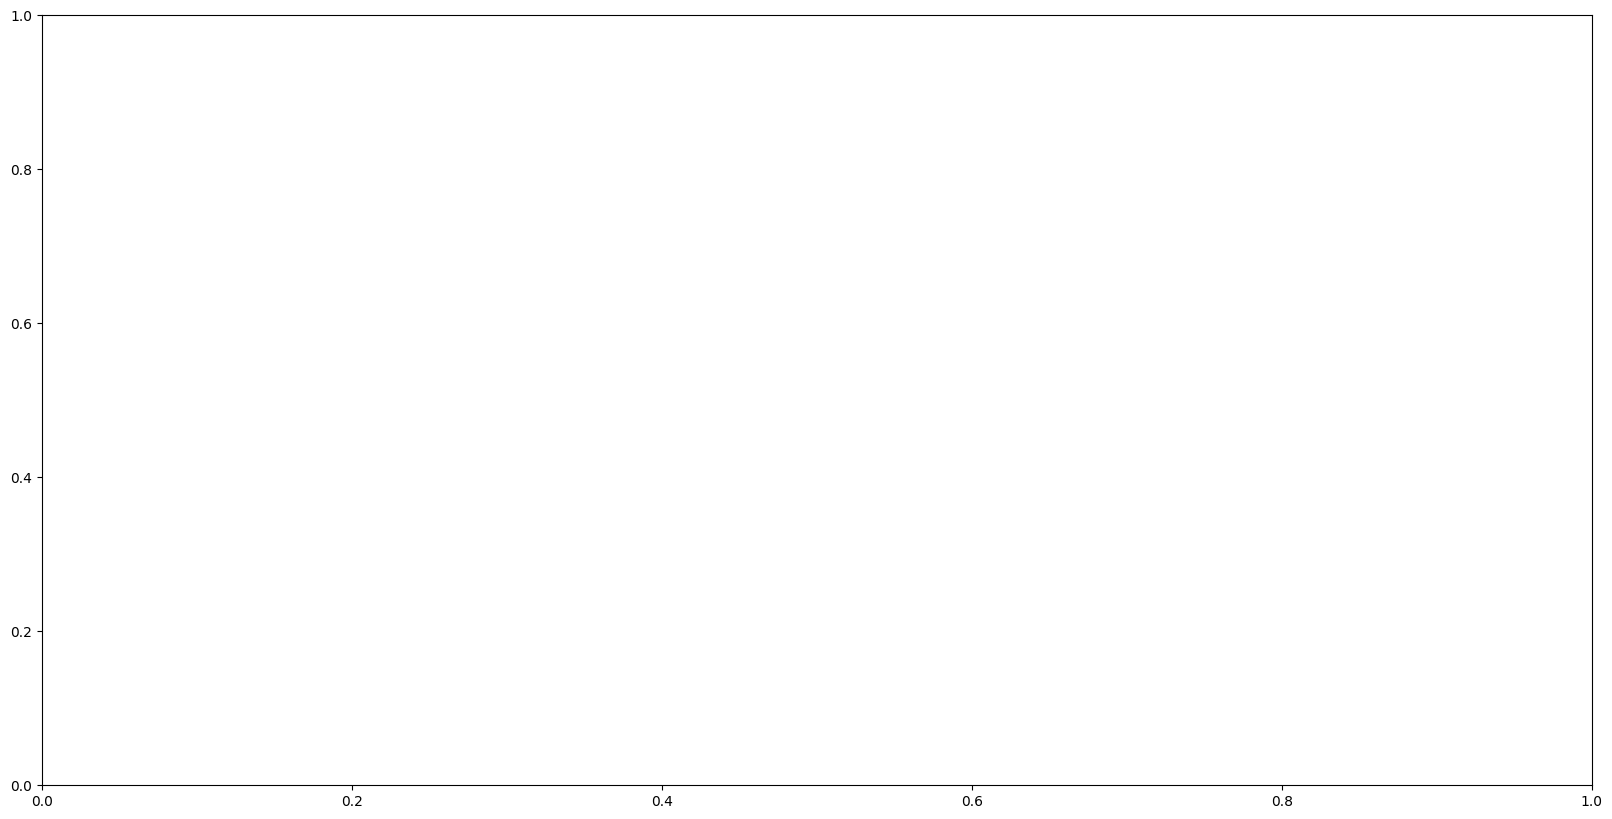

In [14]:
selected_lvl2 = ['PSICOLEPTICOS', 'PSICOANALEPTICOS']
df_filtered = df_nerv[df_nerv["grup ATC nivell 2"].isin(selected_lvl2)]
df_fem = df_filtered[df_filtered["sexe"] == "Dona" ]


# Aggregate by age × level 3
lvl3_by_age = (
    df_fem
    .groupby(["grup d'edat", "grup ATC nivell 3"])["nombre de receptes"]
    .sum()
    .unstack(fill_value=0)
)

# Ensure age ordering (same as your original code)
lvl3_by_age = lvl3_by_age.loc[df["grup d'edat"].cat.categories]

# Normalize to percentage per age group
lvl3_pct = lvl3_by_age.div(lvl3_by_age.sum(axis=1), axis=0) * 100

# Use a nice distinct palette
colors = sns.color_palette("tab20", n_colors=len(lvl3_pct.columns))

# Plot
plt.figure(figsize=(20, 10))
plt.stackplot(
    lvl3_pct.index,
    lvl3_pct.T,
    colors=colors,
    labels=lvl3_pct.columns,
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylabel("Percentage")
plt.title("ATC Level 3 (SISTEMA NERVIOSO) — Share of Prescriptions by Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
selected_lvl2 = ['PSICOLEPTICOS', 'PSICOANALEPTICOS']
df_filtered = df_nerv[df_nerv["grup ATC nivell 2"].isin(selected_lvl2)]

# Aggregate by age × level 3
lvl3_by_age = (
    df_filtered
    .groupby(["grup d'edat", "grup ATC nivell 4"])["nombre de receptes"]
    .sum()
    .unstack(fill_value=0)
)

# Ensure age ordering (same as your original code)
lvl3_by_age = lvl3_by_age.loc[df["grup d'edat"].cat.categories]

# Normalize to percentage per age group
lvl3_pct = lvl3_by_age.div(lvl3_by_age.sum(axis=1), axis=0) * 100

# Use a nice distinct palette
colors = sns.color_palette("tab20", n_colors=len(lvl3_pct.columns))

# Plot
plt.figure(figsize=(20, 10))
plt.stackplot(
    lvl3_pct.index,
    lvl3_pct.T,
    colors=colors,
    labels=lvl3_pct.columns,
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylabel("Percentage")
plt.title("ATC Level 3 (SISTEMA NERVIOSO) — Share of Prescriptions by Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "font.size": 18,        # base font size
    "axes.titlesize": 22,   # title font
    "axes.labelsize": 20,   # axis labels
    "xtick.labelsize": 16,  # x-axis tick labels
    "ytick.labelsize": 16,  # y-axis tick labels
    "legend.fontsize": 16   # legend text
})

# assume lvl3_pct and totals are defined as before
x = np.arange(len(lvl3_pct.index))
y_stack = lvl3_pct.values.T

fig, ax = plt.subplots(figsize=(20, 10))

# stacked percentages (base colors)
base_colors = sns.color_palette("Dark2", n_colors=len(lvl3_pct.columns))
cumulative = np.zeros(len(x))
for i, (col, y) in enumerate(zip(lvl3_pct.columns, y_stack)):
    y2 = cumulative + y
    ax.fill_between(x, cumulative, y2, color=base_colors[i], label=col, linewidth=0)
    cumulative = y2

ax.set_xticks(x)
ax.set_xticklabels(lvl3_pct.index, rotation=45)
ax.set_ylabel("Percentage")
ax.margins(x=0, y = 0)
# ax.set_title("ATC Level 3 — Share of Prescriptions by Age Group (Female)")

# secondary axis for totals
ax2 = ax.twinx()
# plot totals as a thick line (or use ax2.fill_between for an area)
ax2.plot(x, totals.values, color="black", linewidth=2.5, marker="o", label="Total prescriptions")
ax2.set_ylabel("Total prescriptions")
ax2.margins(x=0, y = 0)

# optionally make the totals easier to compare by adding markers or smoothing

# legends: one for stacks, one for totals
handles, labels = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    frameon=False
)

# ax2.legend(
#     loc="upper left",
#     bbox_to_anchor=(0.5, 1.08),
#     frameon=False
# )

plt.tight_layout()
plt.savefig("../plots/age_evolution_mental.pdf")
plt.show()


In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(lvl3_pct.T, cmap="viridis", annot=False)
plt.title("ATC Level 3 (Sistema Nervioso) — Prescription Share by Age Group")
plt.ylabel("ATC Level 3")
plt.xlabel("Age group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### gender analyses

In [ ]:
def gender_pct(df, atc_col):
    """
    Returns: a dict { 'Male': pivot, 'Female': pivot }
    Each pivot is: index = age, columns = ATC categories, values = % share.
    """
    results = {}
    for sex in ["Home", "Dona"]:      # adapt to your labels if needed
        subset = df[df["sexe"] == sex]

        table = (
            subset
            .groupby(["grup d'edat", atc_col])["nombre de receptes"]
            .sum()
            .unstack(fill_value=0)
            .loc[df["grup d'edat"].cat.categories]
        )

        pct = table.div(table.sum(axis=1), axis=0) * 100
        results[sex] = pct

    return results

df_nerv = df[df["grup ATC nivell 1"] == "SISTEMA NERVIOSO"]

pct_gender = gender_pct(df_nerv, "grup ATC nivell 2")
male_pct   = pct_gender["Home"]
female_pct = pct_gender["Dona"]


In [ ]:
plt.figure(figsize=(18,6))
plt.stackplot(
    male_pct.index,
    male_pct.T,
    labels=male_pct.columns,
    alpha=0.9
)
plt.title("ATC Level 2 — SISTEMA NERVIOSO (Male)")
plt.xticks(rotation=45)
plt.ylabel("Percentage")
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(18,6))
plt.stackplot(
    female_pct.index,
    female_pct.T,
    labels=female_pct.columns,
    alpha=0.9
)
plt.title("ATC Level 2 — SISTEMA NERVIOSO (Female)")
plt.xticks(rotation=45)
plt.ylabel("Percentage")
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


In [ ]:
delta = female_pct - male_pct

plt.figure(figsize=(18,6))
sns.heatmap(delta.T, cmap="coolwarm", center=0)
plt.title("Female – Male difference (ATC Level 2, Nervioso)")
plt.xlabel("Age group")
plt.ylabel("ATC Level 2")
plt.show()


This heatmap shows **Female minus Male (%)** for each ATC Level 2 group across age.  
- **Red = used more by females**  
- **Blue = used more by males**  
- **White/grey = no major difference**

This gives a *direct*, side-by-side comparison of gender differences without plotting male/female separately.


**1. Analgesics — Females use more in adolescence and adulthood**
- Strong red band from **10–30** → **females use significantly more analgesics**.
- Small male excess at very old age (light blue at 85+).

👉 Reflects known patterns: higher rates of migraine, dysmenorrhea, chronic pain in women.

**2. Psychoanaleptics (antidepressants, stimulants) — Clear gender opposite patterns**
- **Ages 6–15:** Large blue area → **males use far more** (ADHD medication signal).
- **Ages 18–65:** Large red area → **females use more antidepressants**.

👉 Childhood = ADHD effect (male-dominated).  
👉 Adulthood = depression/anxiety effect (female-dominated).

**3. Psycholeptics (anxiolytics, sedatives) — Slight male excess in teens, female excess in midlife**
- Teens: blue = higher male use  
- Midlife (30–65): light red = higher female use  

👉 Fits with anxiety symptoms increasing earlier in men, but long-term anxiolytic/sedative use being more common in women.

**4. Antiepileptics — generally slightly higher in males**
- Mostly blue across all ages.  
- Small red pocket at 10–15.

👉 Epilepsy prevalence is slightly higher in males across most life stages.

**5. Antiparkinsonians — slightly higher in males in older ages**
- Blue tint in 65+ groups.

👉 Parkinson’s disease has a known male bias.

In [ ]:
df_nerv = df[df["grup ATC nivell 1"] == "SISTEMA NERVIOSO"]

pct_gender2 = gender_pct(df_nerv, "grup ATC nivell 3")
male_pct2   = pct_gender2["Home"]
female_pct2 = pct_gender2["Dona"]
delta2 = female_pct2 - male_pct2

plt.figure(figsize=(18,6))
sns.heatmap(delta2.T, cmap="coolwarm", center=0)
plt.title("Female – Male difference (ATC Level 3, Nervioso)")
plt.xlabel("Age group")
plt.ylabel("ATC Level 3")
plt.show()


### mental health, drill down

In [ ]:
df_mh = df_nerv[df_nerv["codi del grup ATC nivell 2"].isin(["N05", "N06"])].copy()
print(df_mh.shape)
df_mh.head()


In [ ]:
plt.figure(figsize=(8,4))
df_mh.groupby("grup ATC nivell 2")["nombre de receptes"].sum().plot(kind="bar")
plt.title("Mental Health — Level 2 Distribution")
plt.ylabel("Prescriptions")
plt.show()


In [ ]:
plt.figure(figsize=(12,5))
df_mh.groupby("grup ATC nivell 3")["nombre de receptes"].sum()\
     .sort_values(ascending=False).plot(kind="bar")
plt.title("Mental Health — Level 3 Drug Classes")
plt.ylabel("Prescriptions")
plt.xticks()
plt.show()


In [ ]:
plt.figure(figsize=(12,5))
df_mh.groupby("grup d'edat")["nombre de receptes"].sum().plot(kind="bar")
plt.title("Mental Health — Prescriptions by Age Group")
plt.ylabel("Prescriptions")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_lvl3_pie(df, age_group, ax):
    """Create pie chart for one age group."""
    subset = df[df["grup d'edat"] == age_group]

    lvl3 = (
        subset.groupby("grup ATC nivell 3")["nombre de receptes"]
        .sum()
        .sort_values(ascending=False)
    )

    lvl3.plot(
        kind="pie",
        ax=ax,
        autopct="%1.1f%%",
        startangle=90,
        pctdistance=0.85
    )
    ax.set_ylabel("")
    ax.set_title(f"ATC Level 3 Distribution — Age {age_group}")


# Create two side-by-side pie charts
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

plot_lvl3_pie(df_mh, "85+", axes[0,0])
plot_lvl3_pie(df_mh, "50-54", axes[1,0])
plot_lvl3_pie(df_mh, "70-74", axes[0,1])
plot_lvl3_pie(df_mh, "40-44", axes[1,1])

plt.tight_layout()
plt.show()


In [ ]:
mh_age_lvl2 = df_mh.groupby(["grup d'edat", "grup ATC nivell 2"])["nombre de receptes"].sum().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(mh_age_lvl2, cmap="viridis")
plt.title("Age × Level 2 Heatmap — Mental Health")
plt.show()


In [ ]:
plt.figure(figsize=(8,4))
df_mh.groupby("sexe")["nombre de receptes"].sum().plot(kind="bar")
plt.title("Mental Health — Gender Differences")
plt.ylabel("Prescriptions")
plt.show()


In [ ]:
gender_lvl2 = df_mh.groupby(["sexe", "grup ATC nivell 2"])["nombre de receptes"].sum().unstack()

gender_lvl2.plot(kind="bar", figsize=(12,5))
plt.title("Mental Health – Gender × ATC Level 2")
plt.ylabel("Prescriptions")
plt.xticks(rotation=0)
plt.show()


In [ ]:
region_lvl2 = df_mh.groupby(["regió sanitària", "grup ATC nivell 2"])["nombre de receptes"].sum().unstack()

plt.figure(figsize=(14,6))
sns.heatmap(region_lvl2.div(region_lvl2.sum(axis=1), axis=0), cmap="mako")
plt.title("Regional Medication Mix — Mental Health (Normalized Across Level 2)")
plt.show()


In [ ]:
year_mh = df_mh.groupby("any")["nombre de receptes"].sum()

plt.figure(figsize=(10,4))
year_mh.plot(marker="o")
plt.title("Mental Health Prescriptions Over Time")
plt.ylabel("Prescriptions")
plt.grid(True)
plt.show()


In [ ]:
mh_time_lvl2 = df_mh.groupby(["any", "grup ATC nivell 2"])["nombre de receptes"].sum().unstack()

mh_time_lvl2.plot(figsize=(12,6), marker="o")
plt.title("Time Trend — Mental Health Level 2 Categories")
plt.ylabel("Prescriptions")
plt.grid(True)
plt.show()


#### comparing 2016 vs 2023 and how age/ppl shifted

In [ ]:
import matplotlib.pyplot as plt

year1 = 2018
year2 = 2023

# Filter data
t1 = df_mh[df_mh["any"] == year1].copy()
t2 = df_mh[df_mh["any"] == year2].copy()

# Aggregate by age
age_t1 = t1.groupby("grup d'edat")["nombre de receptes"].sum()
age_t2 = t2.groupby("grup d'edat")["nombre de receptes"].sum()

# Ensure same age ordering
ages = sorted(age_t1.index, key=lambda x: int(x.split("-")[0]) if "-" in x else 999)
age_t1 = age_t1.reindex(ages)
age_t2 = age_t2.reindex(ages)

# Plot
plt.figure(figsize=(14,6))

plt.plot(ages, age_t1.values, marker="o", label=f"{year1}")
plt.plot(ages, age_t2.values, marker="o", label=f"{year2}")

plt.title(f"Mental Health Prescriptions by Age Group: {year1} vs {year2}")
plt.ylabel("Number of prescriptions")
plt.xlabel("Age group")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Total mental health prescriptions per year
year_totals = df_mh.groupby("any")["nombre de receptes"].sum()

# Compute year-to-year change
year_change = year_totals.diff()

print(year_totals)
print(year_change)



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
year_change.plot(kind="bar", color="steelblue")
plt.axhline(0, color="black", linewidth=1)
plt.title("Year-to-Year Change in Mental Health Prescriptions")
plt.ylabel("Change in prescriptions vs previous year")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [ ]:
age_year = df_mh.groupby(["any", "grup d'edat"])["nombre de receptes"].sum().unstack()

# year-to-year differences
age_year_diff = age_year.diff().dropna()

# Plot heatmap of jumps
plt.figure(figsize=(14,7))
sns.heatmap(age_year_diff.T, cmap="coolwarm", center=0)
plt.title("Year-to-Year Change in Mental Health Prescriptions by Age Group")
plt.xlabel("Year")
plt.ylabel("Age group")
plt.tight_layout()
plt.show()
